# How do health metrics affect math course performance in highschoolers?

## Introduction

#### Question

How do health metrics affect math course performance in highschoolers?

#### Dataset

This data focuses on the academic performance of secondary school students in two Portuguese schools. It includes various factors such as student grades, demographic information, social aspects, and school-related features. The data was collected through school reports and questionnaires. Two datasets are provided, specifically examining student performance in two different subjects: Mathematics and Portuguese.



In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Load the data from the web
set.seed(2000)
path <- 'https://raw.githubusercontent.com/JadenMajid/dsci-100-student-grades/main/student-mat.csv'

og_data <- read_csv2(file = path) |>
    mutate(Talc = Walc + Dalc)
    # mutate(Walc = as_factor(Walc)) |>
    # mutate(Dalc = as_factor(Dalc)) |>
    # mutate(Talc = as_factor(Talc))

# training data
split <- og_data |>
    initial_split(prop = 0.75, strata = G3)

data <- training(split)
test_data <- testing(split)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 395 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
sum_stats <- data |>
    group_by(sex) |>
    summarize(avg_G3 = mean(G3), avg_walc = mean(Walc), avg_dalc = mean(Dalc), 
              avg_health = mean(health), avg_studytime = mean(studytime), avg_absences = mean(absences))
sum_stats


sex,avg_G3,avg_walc,avg_dalc,avg_health,avg_studytime,avg_absences
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,9.90303,1.969697,1.260606,3.412121,2.278788,6.424242
M,10.94574,2.751938,1.767442,3.837209,1.767442,4.992248


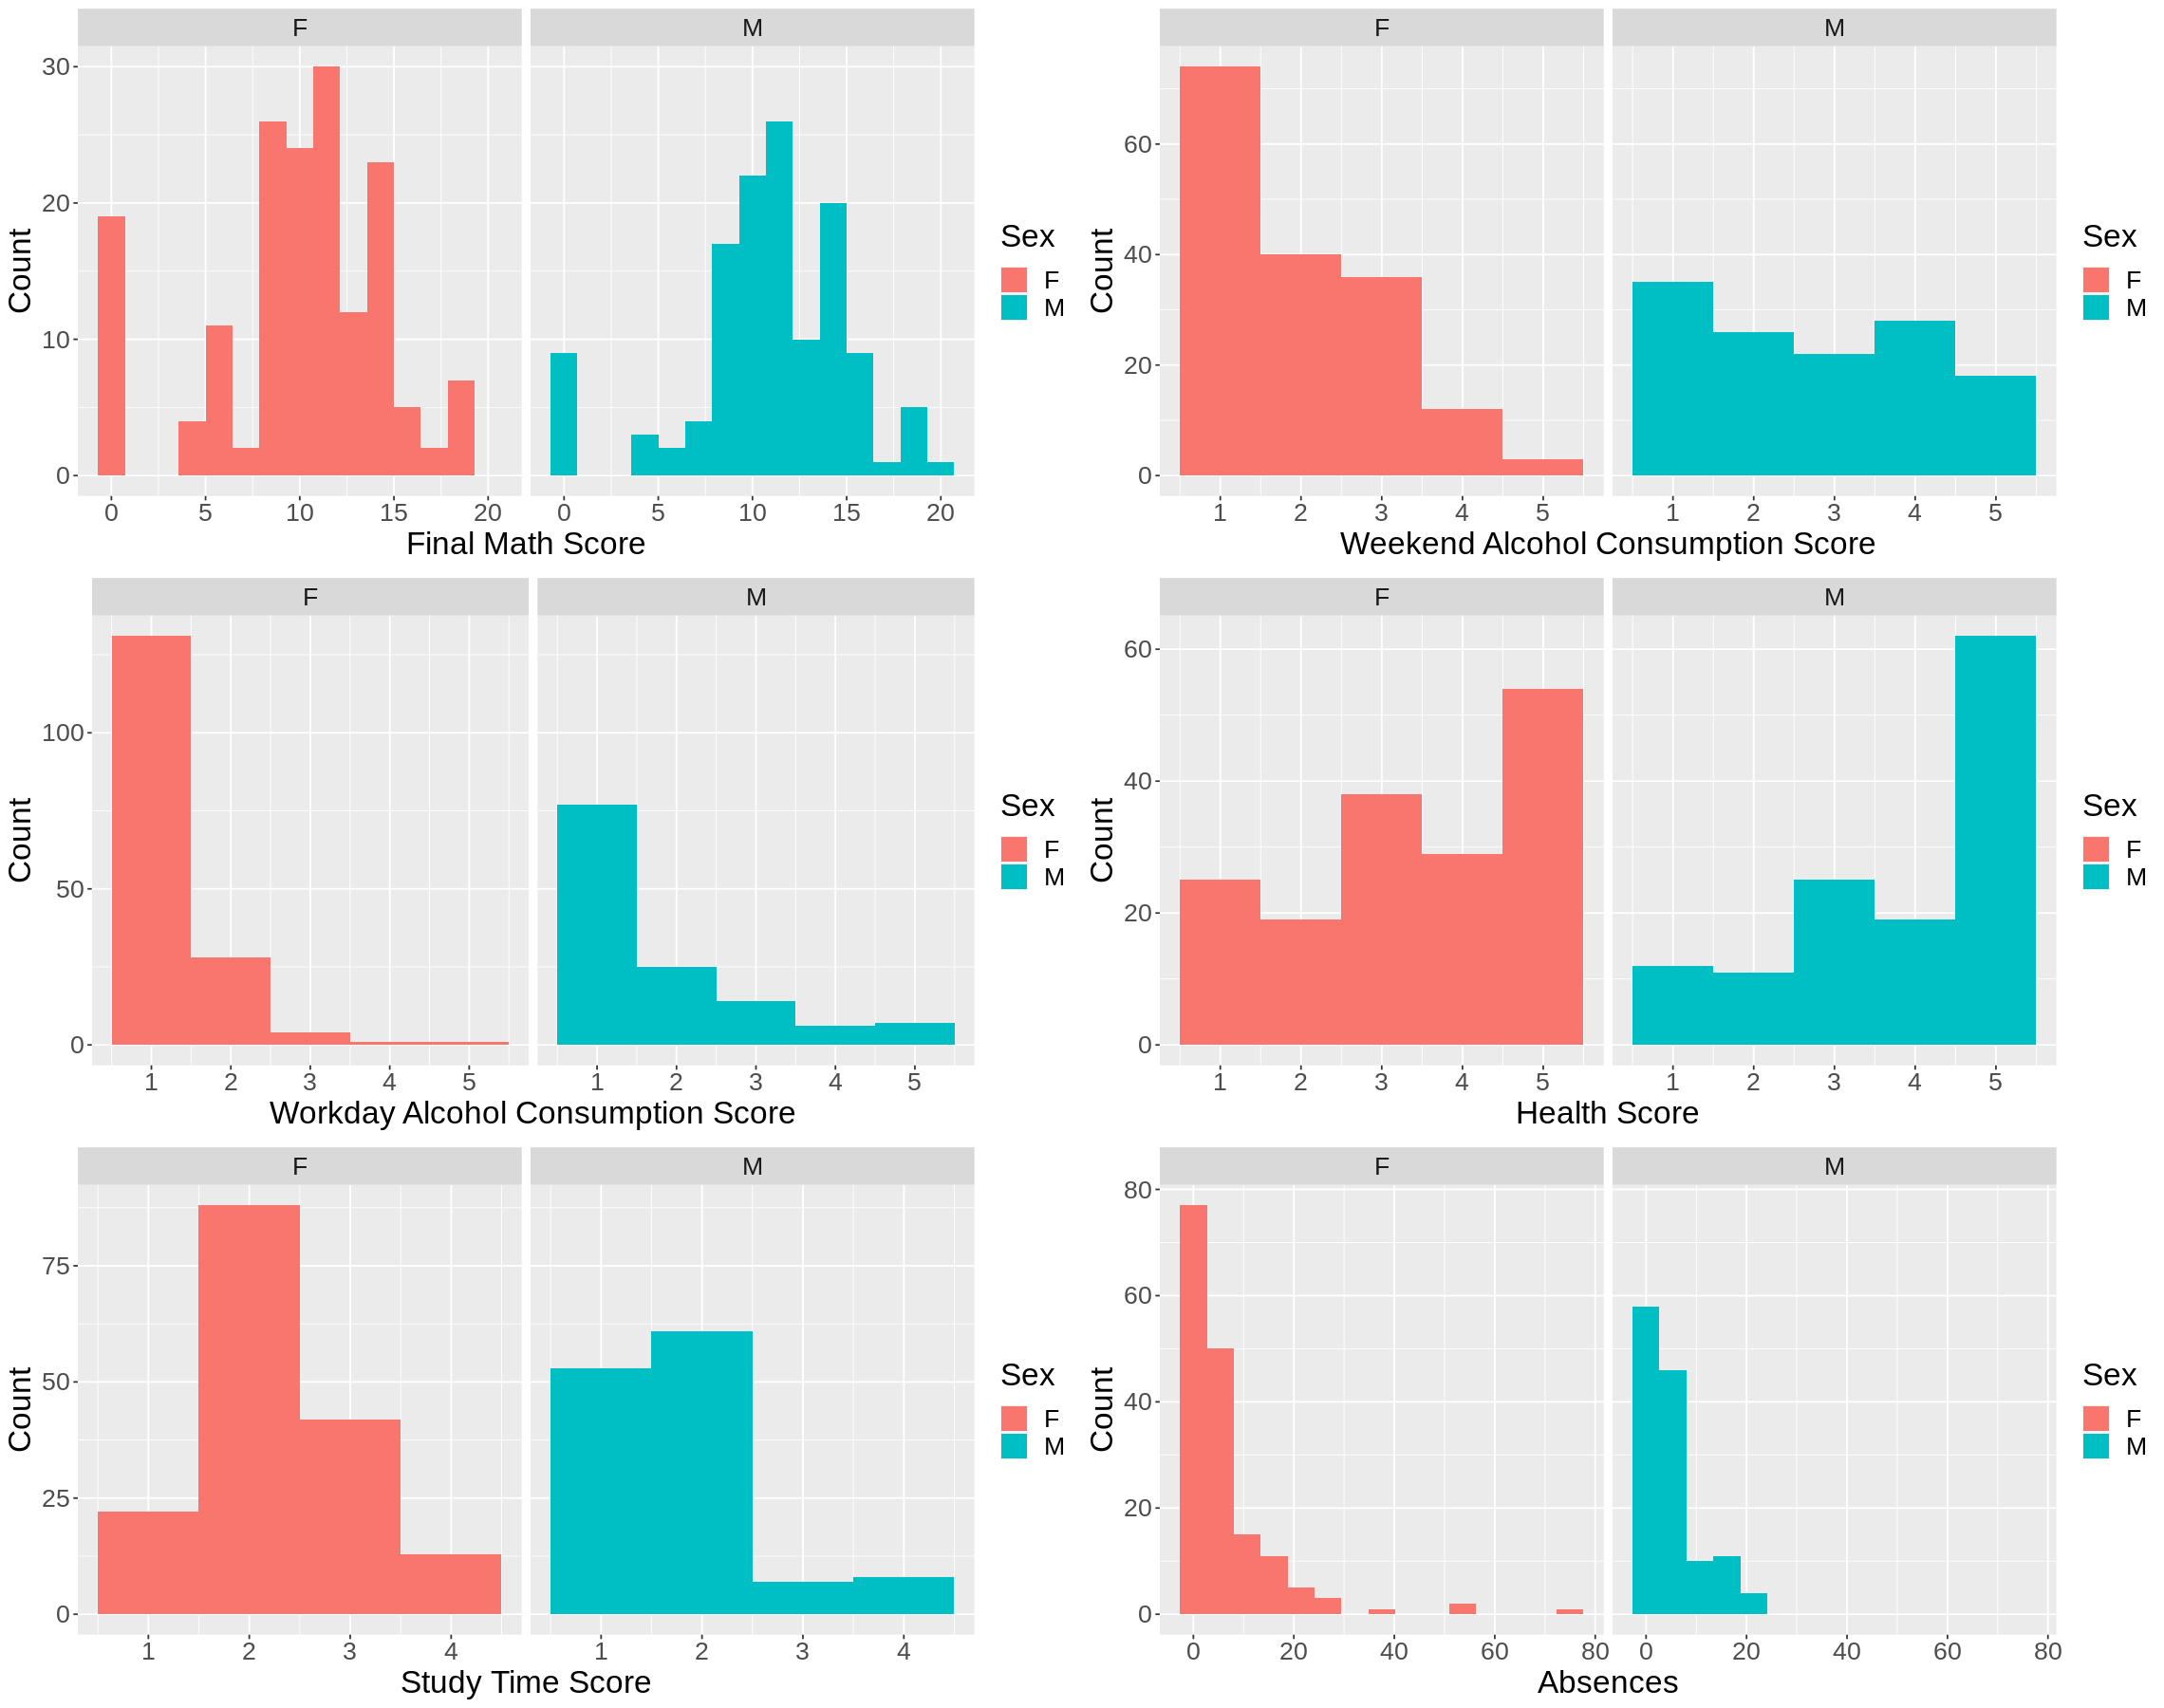

In [4]:
options(repr.plot.width = 19, repr.plot.height = 15)

G3_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = G3, fill = as_factor(sex)), bins = 15) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Final Math Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


walc_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = Walc, fill = as_factor(sex)), bins = 5) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Weekend Alcohol Consumption Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


dalc_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = Dalc, fill = as_factor(sex)), bins = 5) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Workday Alcohol Consumption Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


health_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = health, fill = as_factor(sex)), bins = 5) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Health Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


studytime_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = studytime, fill = as_factor(sex)), bins = 4) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Study Time Score", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


absences_plot <- data |>
    ggplot() +
        geom_histogram(aes(x = absences, fill = as_factor(sex)), bins = 15) +
        facet_grid(cols = vars(sex)) +
        labs(x = "Absences", y = "Count", fill = "Sex") +
        theme(text = element_text(size = 20))


top_row <- plot_grid(G3_plot, walc_plot)
middle_row <- plot_grid(dalc_plot, health_plot)
bottom_row <- plot_grid(studytime_plot, absences_plot)
summary_plot <- plot_grid(top_row, middle_row, bottom_row, ncol = 1)
summary_plot

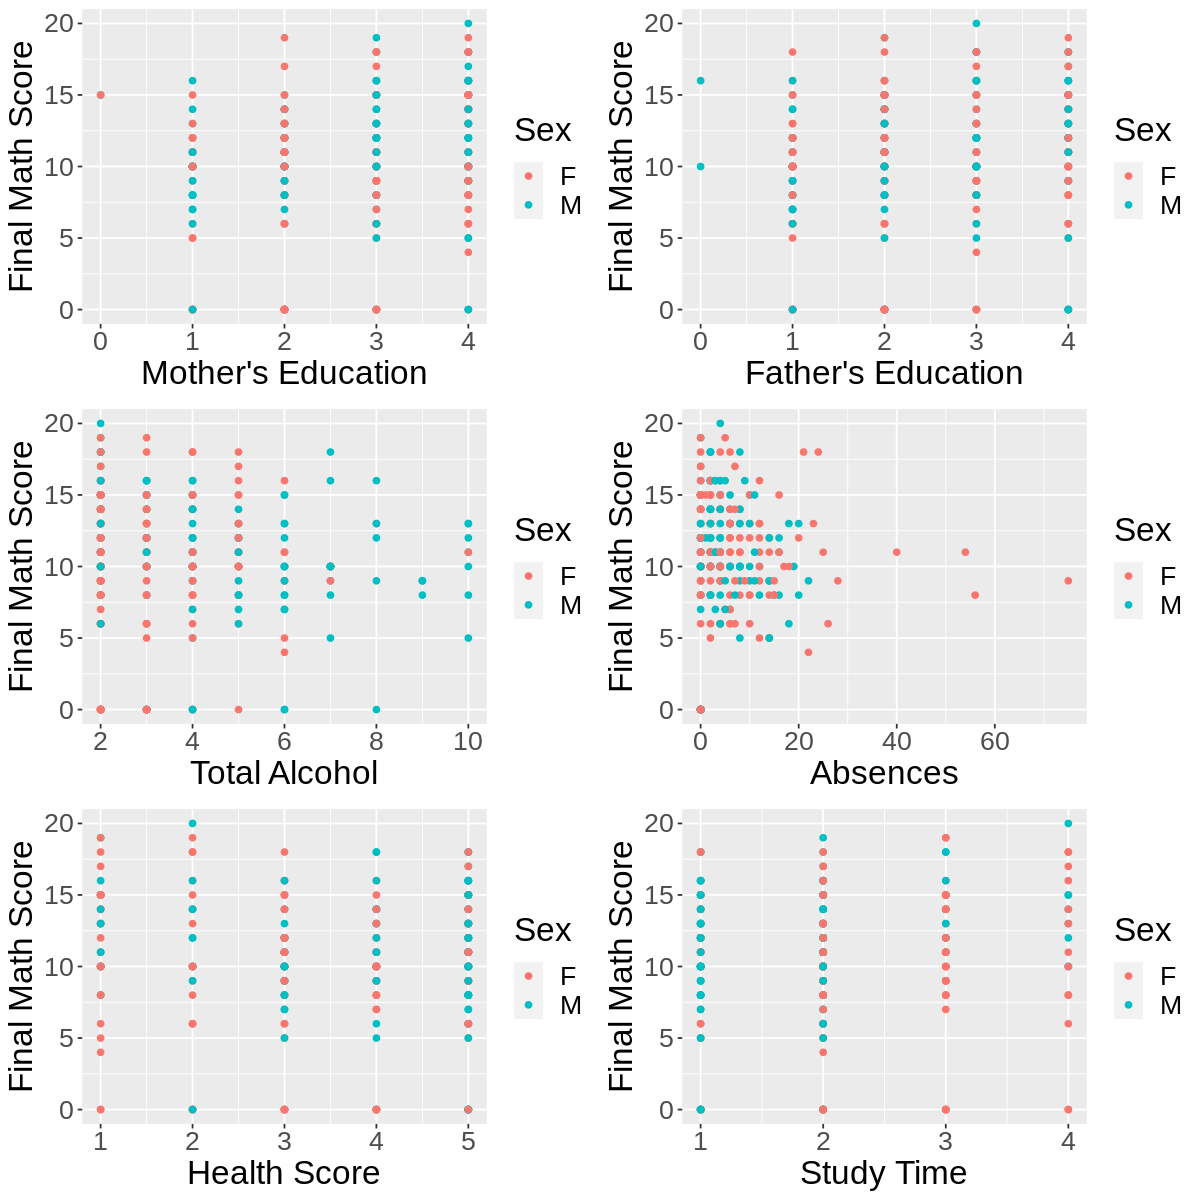

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)

medu_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = Medu, y = G3, color = sex)) +
        labs(x = "Mother's Education", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


fedu_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = Fedu, y = G3, color = sex)) +
        labs(x = "Father's Education", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


talc_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = Talc, y = G3, color = sex)) +
        labs(x = "Total Alcohol", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


absences_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = absences, y = G3, color = sex)) +
        labs(x = "Absences", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


health_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = health, y = G3, color = sex)) +
        labs(x = "Health Score", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


study_vs_G3 <- data |>
    ggplot() +
        geom_point(aes(x = studytime, y = G3, color = sex)) +
        labs(x = "Study Time", y = "Final Math Score", color = "Sex") +
        theme(text = element_text(size = 20))


top_row_2 <- plot_grid(medu_vs_G3, fedu_vs_G3)
middle_row_2 <- plot_grid(talc_vs_G3, absences_vs_G3)
bottom_row_2 <- plot_grid(health_vs_G3, study_vs_G3)
summary_plot_2 <- plot_grid(top_row_2, middle_row_2, bottom_row_2, ncol = 1)
summary_plot_2

# Methods

Data analysis will be conducted by using the following variables: health, sex, weekend/workday alcohol consumption, study time, and absences. A classification model will be trained using a subset of this dataset to predict G3 Mathematics scores. Before training, the data will be properly normalized. This model will be tested on the testing subset of the dataset. To choose the optimal number of nearest neighbours to consider, the training dataset will be further split up to validate out choice of number of neighbours. A classification model is chosen since the reported G3 scores are natural numberse from 0 to 20. 

The variables that appear to show the most correlation with the final math scores will be used in the model, and can reference the above plots for those variables.

#### Expectations

It is expected to find Mathematic scores and these "health" variables will be inversely correlated. As health declines, one would expect a student's scores to decline as well. This may occur with increasing weekend and workday alcohol consumption, lower health scores, increased absences, and lower study time. If such a relationship is seen in the analysis, perhaps these school districts will place more emphasis on student livelihood and wellbeing as a way to improve their academic performance. This may lead to other interesting investigations, such as looking into relationships between academic performance and a parent's marital status, or other external factors that may affect a student's schooling.

# Alternative Wine Dataset
This dataset has more continuous variables, which may make it easier to create a regression/classification model to. There are also stronger correlations between the variables.

# Predicting a Wine’s Cultivator from its Chemical Characteristics

This dataset is a result of chemical analysis done on different wines grown in the same Italien region, but originating from 3 different cultivators. Each row contains the quantity of 13 different chemical constituents found in a wine from a particular cultivator. This model will attempt to use these measurements to predict a wine’s cultivator, answering the question: “based on the chemical composition of a wine, can its origin be determined?”

Please note no units were provideed in the dataset or website.

In [6]:
# read data
wine_path <- 'https://raw.githubusercontent.com/adrianwu2000/toy_ds_project/main/wine.data'

wine_data <- read_delim(file = wine_path, delim = ",", col_names = FALSE) |>
    mutate(X1 = as_factor(X1)) |>
    select(-X14)

# column names obtained from UCI Ml website
colnames(wine_data) <- c('alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium', 'total_phenols',
                         'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
                         'hue', 'ODnum', 'proline')
# split data
split <- wine_data |>
    initial_split(prop = 0.75, strata = alcohol)

wine_training_data <- training(split)
wine_test_data <- testing(split)

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Preliminary Exploratory Data Analysis

In [7]:
# mean
mean_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, mean))
mean_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13.70705,2.043409,2.450227,17.18409,105.25000,2.808182,2.962273,0.2811364,1.840909,5.507727,1.0631818,3.161136
2,12.24245,1.807170,2.236226,20.04717,95.83019,2.271509,2.086038,0.3518868,1.690755,3.054717,1.0693585,2.751321
3,13.17528,3.296667,2.415000,21.31944,99.00000,1.700833,0.787500,0.4455556,1.168889,7.382222,0.6744444,1.693889


In [8]:
# max
max_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, max))
max_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.38,4.04,2.87,22.5,128,3.88,3.93,0.42,2.91,8.9,1.28,4.00
2,13.67,4.43,3.23,30.0,162,3.52,5.08,0.63,3.58,6.0,1.71,3.69
3,14.34,5.51,2.86,25.5,123,2.80,1.57,0.63,2.70,13.0,0.91,2.47


In [9]:
# minimum
min_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, min))
min_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12.85,1.35,2.04,11.2,89,2.20,2.19,0.17,1.25,3.52,0.82,2.51
2,11.03,0.74,1.36,10.6,70,1.10,0.57,0.13,0.41,1.28,0.69,1.67
3,12.25,1.24,2.10,17.5,80,0.98,0.34,0.17,0.64,4.00,0.54,1.29


In [10]:
# number of wines from each region
counts <- wine_training_data |>
    group_by(alcohol) |>
    summarize(count = n())
counts

alcohol,count
<fct>,<int>
1,44
2,53
3,36


### Exploratory Visualization

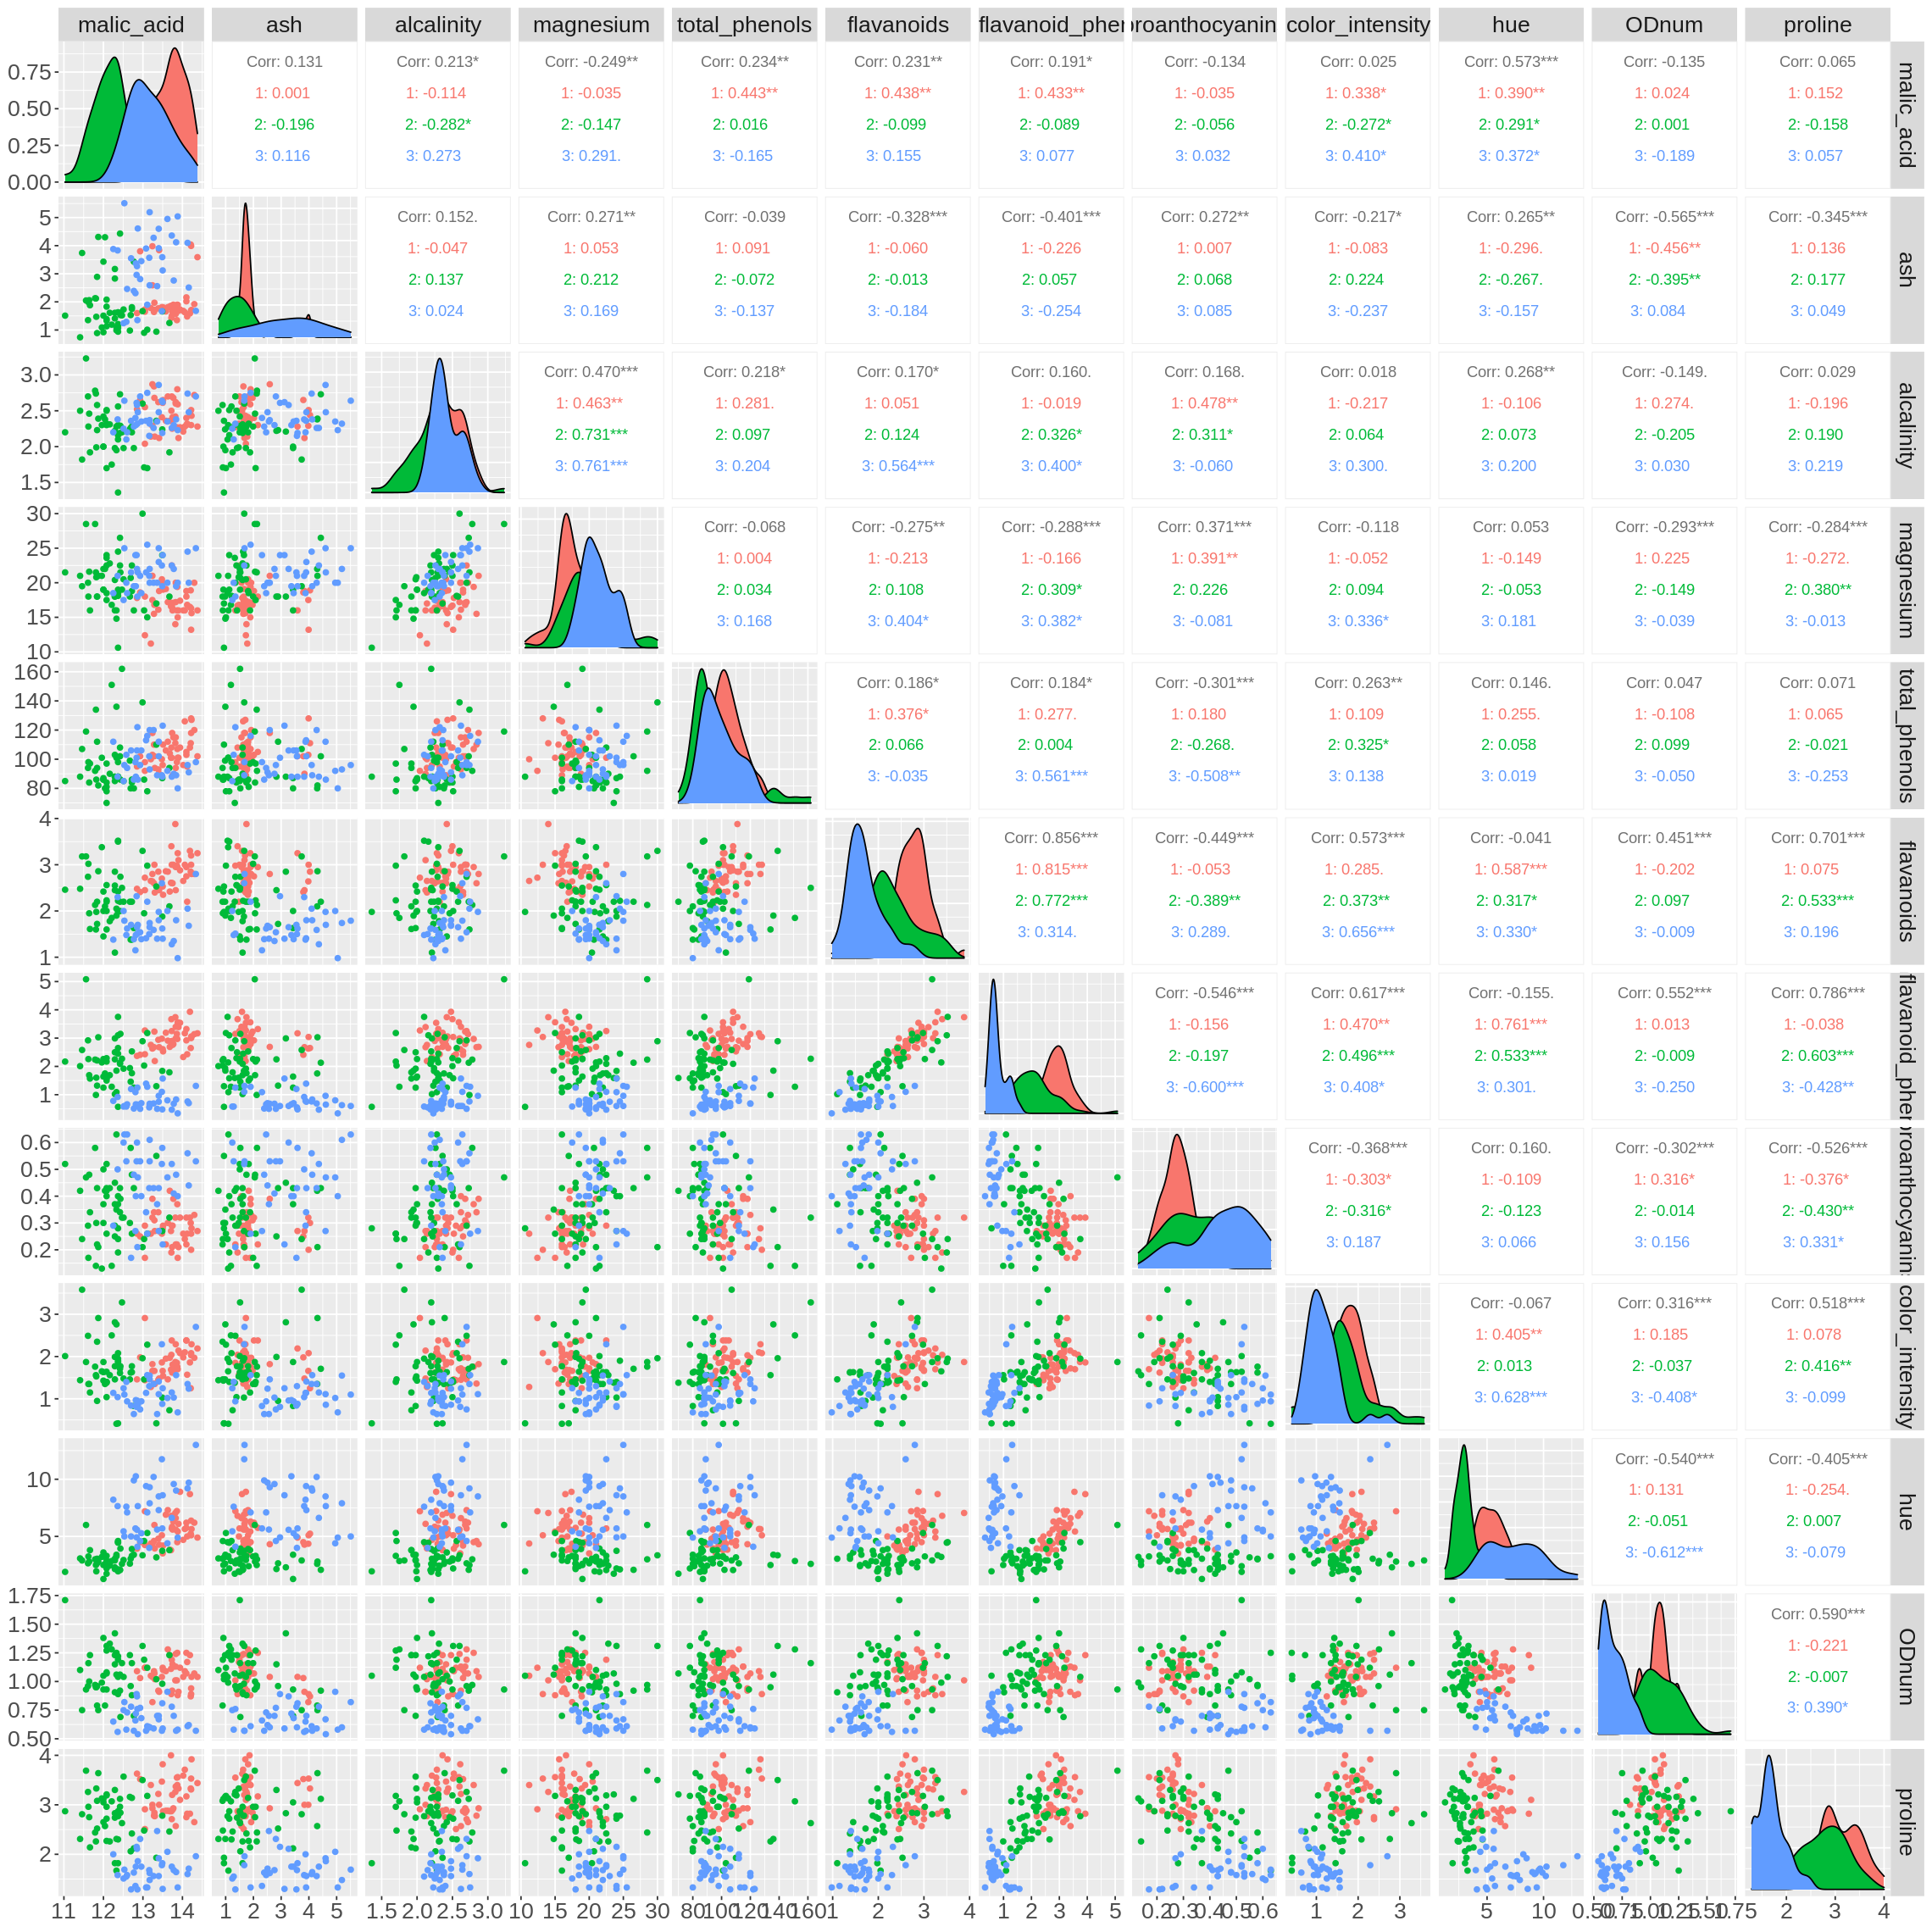

In [11]:
# scatter plots of the variables
options(repr.plot.width = 19, repr.plot.height = 19)
wine_training_data |> 
  ggpairs(columns = 2:13, ggplot2::aes(colour = alcohol))+
    theme(text = element_text(size = 20))#, upper = list(continuous = "density", combo = "box_no_facet")

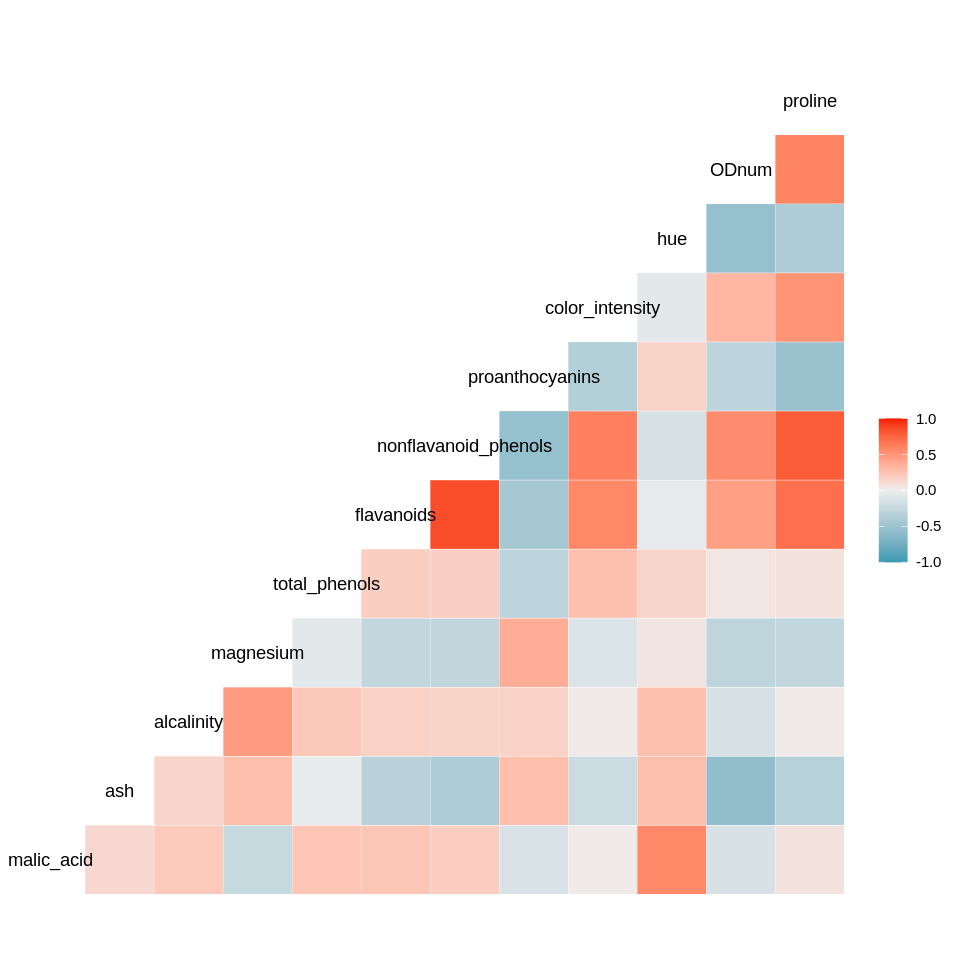

In [ ]:
# correlation plot 
options(repr.plot.width = 8, repr.plot.height = 8)
corr_plot <- wine_training_data |>
    select(-alcohol) |>
    ggcorr() +
        theme(text = element_text(size = 20))
corr_plot

### Methods
A classification model will be used, since the cultivator can only be one of three things. Though there are numerous variables, only two will be chosen, as not all are useful for prediction. 

By looking at the visualization, pairs of variables can be identified as strong candidates for analysis. Examples are the plots of “Malic acid versus Proline” and “Non Flavonoid Phenols versus Hue”. Wines from each region are separated into relatively clear areas in the plot. 

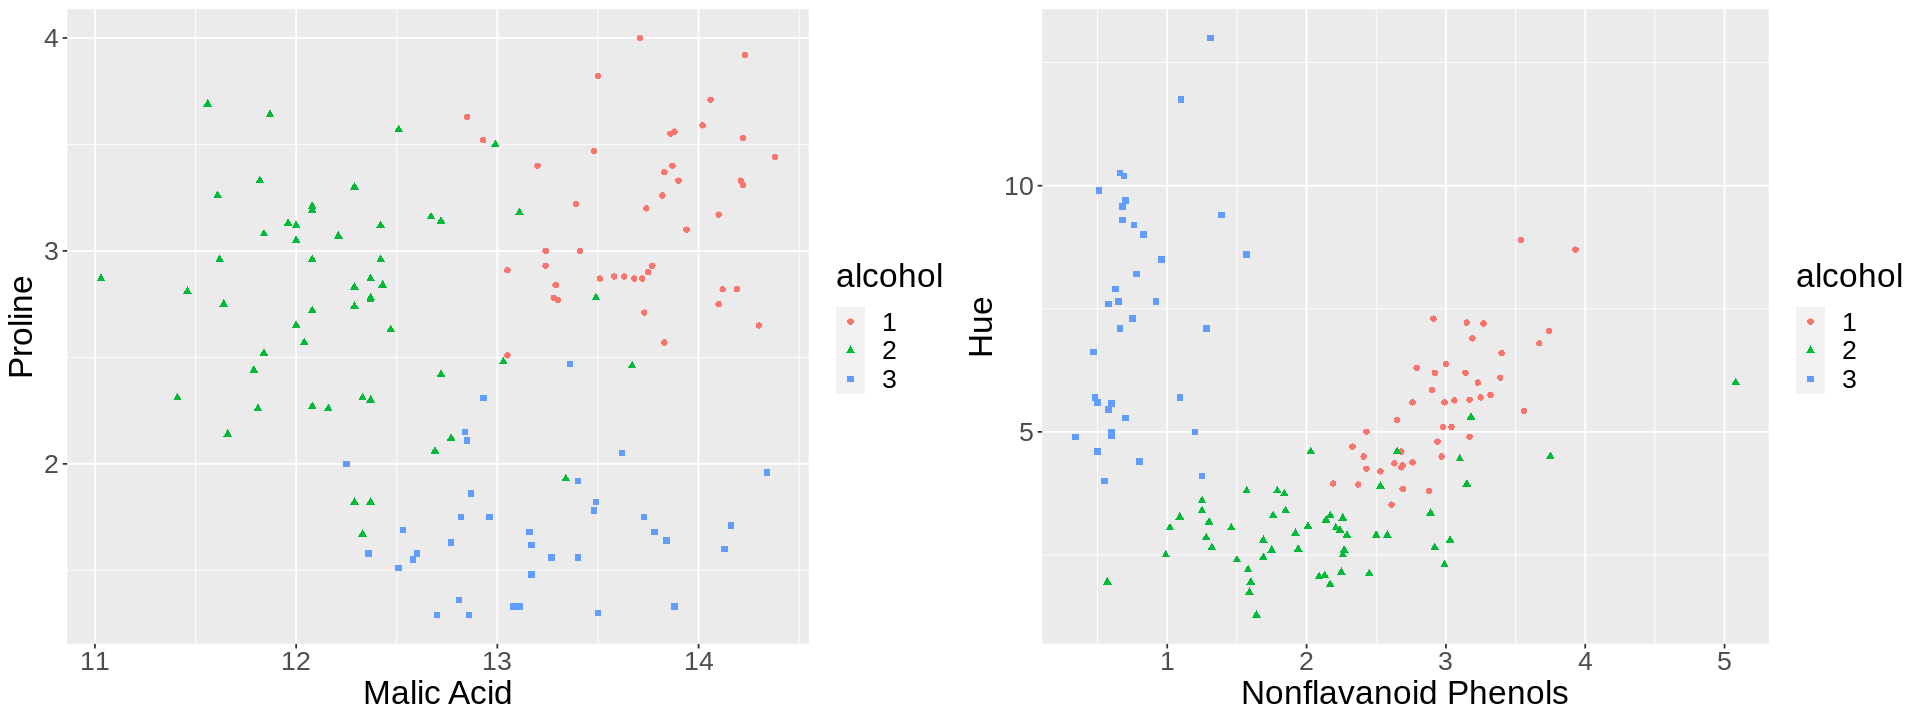

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 6)
malic_acid_proline_plot <- wine_training_data |>
    ggplot(aes(x = malic_acid, y = proline, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline") + 
    theme(text = element_text(size = 20))


nonflavanoid_hue_plot <- wine_training_data |>
    ggplot(aes(x = nonflavanoid_phenols, y = hue, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Nonflavanoid Phenols", y = "Hue") + 
    theme(text = element_text(size = 20))


plot_of_options <- plot_grid(malic_acid_proline_plot, nonflavanoid_hue_plot, ncol = 2)
plot_of_options

A bad example is Alkalinity versus Magnesium. Wines from all the regions are overlapped and closely grouped together, making them indistinguishable.

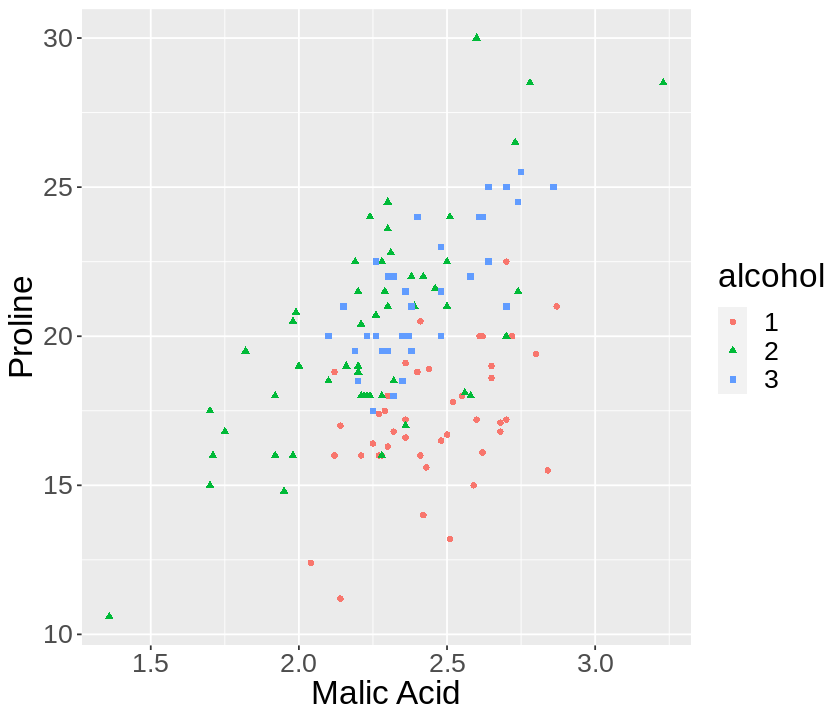

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 6)
alcalinity_magnesium_plot <- wine_training_data |>
    ggplot(aes(x = alcalinity, y = magnesium, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline") + 
    theme(text = element_text(size = 20))
alcalinity_magnesium_plot

While scaling and centering have not been performed yet, this provides a starting point. The choice is subjective, and others may make different choices. Nonetheless, the model will use the following to predict alcohol origin: Hue and Non Flavonoid Phenols. A more rigorous method of choosing the variables may be explored in a future project. 
### Visualization
One way to visualize the results is a scatter plot. Since 2 variables are chosen, results can be easily visualized on a 2D plot. This allows the testing data to be highlighted, allowing for readers to visually see the "goodness" of the model. Areas of the graph where the model will predict what region a wine is from can also be colored. 

### Expectations

Just by looking at the visualization, there are distinct areas where each wine group dominates. This is a good indicator that the model should be able to predict where the wine originates from based on these variables. However, there is some overlapping of the points, which can make it difficult for the model to accurately classify edge cases. Nevertheless, it is expected that this choice of variables will be a good predictor of the data's wine origin. 

Such findings may allow for wineries to selectively choose wines from certain regions based on their chemical composition. Wines from certain regions, such as Napa Valley, or types of grapes, such as Cabernet Sauvignon, may have a distinct chemical composition that makes their flavor popular and desirable. The findings of this model could allow for wineries to alter the chemical composition of cheaper wines to match those from more expensive regions.

This leads to the natural question of where these chemicals come from, and what makes the wines from these regions have varying levels of these chemicals - a topic for future investigation.
